# Questions
1. What is apStarLSF? What is the -xxxxx- data in apStar?
2. Why are there duplicate target_id's in the AllStar ASPCAP label data?
3. Where can I get accurate wavelength arrays for the data?
4. What are we actually fitting, and using what?

Every fits file contains spectrum data for each star over multiple "visits". This is probably just time-seperated observations of the same star. It also contains a combined spectra of all visits. The combined visit has hopefully been doppler shifted, which is needed, since the earth might be moving in different directions and velocities for each observation. 

# 1. DATA FETCH

APOGEE provides their spectrum data in a series of ".fits" files. The files are sorted in directories after their location ID, and named after their object ID. Since we're only looking at 4 location IDs, we do a seperate request of all files in these 4 directories using wget. The request is done using the following wget commands, to ensure only the desired files are requested, and that nothing else funky happens:

* -q --quiet (prevents wget prints.)
* -r --recursive (makes wget search through all hyperlinks in the provided directory, which contains our desired files.)
* -np --no-parent (prevents wget from recursively searching parent directories, so we don't download the entire internet.)
* -nd --no-directories (prevents wget from downloading directories.)
* -e robots=off (executes the command "robots=off", which ensures wget doesn't search the robot.txt anti-parse file included in the webpage.)
* -P --directory-prefix (where we want to save our files.)
* -A --accept (only include files following this pattern.)
* -R --reject (exlcude files following this pattern. There is a bunch of similar-looking files in the directory. Don't know what they are, but we don't want them.)

We also include APOGEEs allStar file, which among other things contains the labels we are going to use.

Executing this pulls down ~3000 files, for a combined of ~8GB.

In [1]:
# ! mkdir -p stars/4230/
# ! mkdir -p stars/4262/
# ! mkdir -p stars/5162/
# ! mkdir -p stars/4241/

# ! wget -r -q -np -nd -e robots=off -P stars/4230/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4230/
# ! wget -r -q -np -nd -e robots=off -P stars/4262/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4262/
# ! wget -r -q -np -nd -e robots=off -P stars/5162/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/5162/
# ! wget -r -q -np -nd -e robots=off -P stars/4241/ -A 'apStar-r8-*.fits' -R 'apStar-r8-*-*.fits' https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/apo25m/4241/
# ! wget -q -P stars/ https://data.sdss.org/sas/dr14/apogee/spectro/redux/r8/stars/l31c/l31c.2/allStar-l31c.2.fits

# 2. ANALYSIS
We're gonna be storing all IDs and scalar data in a Pandas DataFrame object called "data", and the flux data and error in a 2-dimensional array, as DataFrames aren't great with multidimentional data. Below, we look at all the filenames we fetched with wget to extract object and location IDs to our DataFrame. We then parse through all the files and extract their flux and flux error data.

## 2.1 Multi-visit data
Now, there are several sets of flux (and error) data provided in the .fits files for each star. Each visit is simply a spectrum observation done over some continous exposure time. Multiple visits are usually performed for each star, at different times. These visits will need to be Doppler shifted to some reference velocity, since they might have been done at different points in the Earth's orbit, and therefore have different relative velocities.

The visits are combined into two combined spectra, with different weighing. The first is pixel-based, and the second uses a more combined, global weighing. We will be using the globaly weighted one.

We will also pull down the APOGEE error bitmask, for later use.

In [230]:
import sys
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import corner
import scipy.interpolate
from tqdm import tqdm
from astropy.io import fits
from os import listdir
from os.path import isfile, join

import astropy
astropy.__version__

'3.1.1'

In [25]:
obj_ids = []
loc_ids = []
for loc in ['4230', '4262', '5162', '4241']:
    filenames = listdir('stars/' + loc)
    for name in filenames:
        if isfile('stars/' + loc + '/' + name):
            name = name.split('r8-')[1]
            name = name.split('.fits')[0]
            obj_ids.append(name)
            loc_ids.append(loc)

nr_stars = len(obj_ids); print(f"Fetched data for {nr_stars} stars.")
data = pd.DataFrame()
data['obj_id'] = np.array(obj_ids, dtype=str)
data['loc_id'] = np.array(loc_ids, dtype=str)
data['target_id'] = data['loc_id'].copy() + '.' + data['obj_id'].copy()
del obj_ids, loc_ids

Fetched data for 2723 stars.


In [26]:
nr_pixels = 8575
flux_data = np.zeros((nr_stars, nr_pixels), dtype=np.float32)  # 8575 seems to be the number of flux-pixels in each dataset.
flux_error_data = np.zeros((nr_stars, nr_pixels), dtype=np.float32)
bitmask = np.zeros((nr_stars, nr_pixels), dtype=int)

for i in tqdm(range(nr_stars)):
    filename = 'stars/' + data['loc_id'][i] + '/apStar-r8-' + data['obj_id'][i] + '.fits'
    with fits.open(filename) as infile:
        flux_data[i] = (infile[1].data)[1]
        flux_error_data[i] = (infile[2].data)[1]
        bitmask[i] = (infile[3].data)[1]

with fits.open(filename) as infile:
    CRVAL1 = infile[0].header['CRVAL1']
    CDELT1 = infile[0].header['CDELT1']
wl = np.logspace(CRVAL1, CRVAL1 + (nr_pixels-1)*CDELT1, nr_pixels)

100%|██████████| 2723/2723 [00:12<00:00, 225.71it/s]


935369

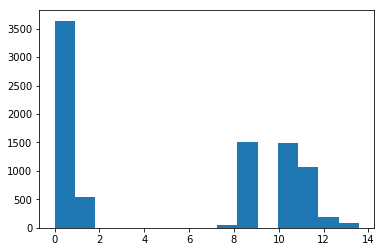

In [27]:
plt.hist(np.log(bitmask[0]+1)/np.log(2), bins=15)
np.sum(bitmask == 2**9)

## 1.1 Taking a look
We now have the datasets flux_data, flux_error_data, obj_ids, and loc_ids, all matched by index. 

flux_data and flux_error_data is (2723)x(8575) arrays, as there are initally 2723 stars, each with flux observations at 8575 different wavelengths. Below we have plotted the spectrum and error spectrum of 3 chosen stars. The entire spectrums are plotted to the left, and a zoomed in, more readable version is on the right. Since the errors are very small, and the data very noisy, plotting errorbars on the data is inconvenient.

A few things are imendiately apparent. There are pixels with no flux-data in all 3 spectrums. These pixels are marked with errors of 1e10. On the more readable spectrums on the right, we see that the errors tend to have a convex form, with most on a rather welldefined curve, with some outliers.

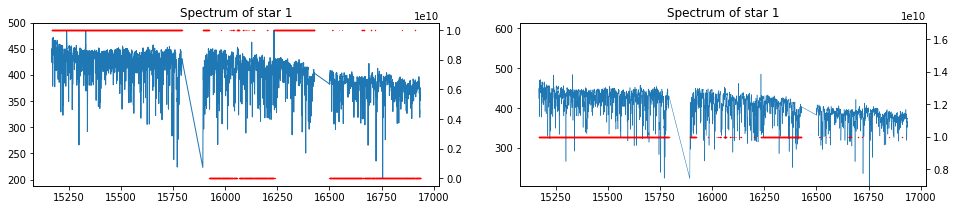

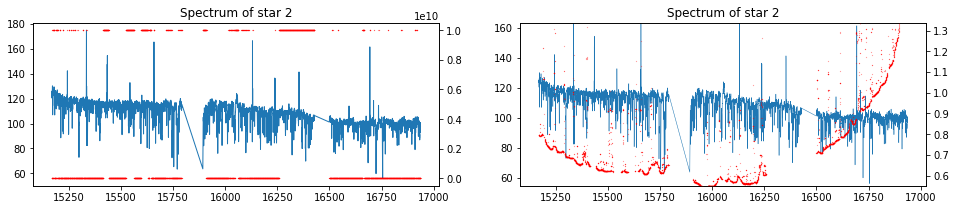

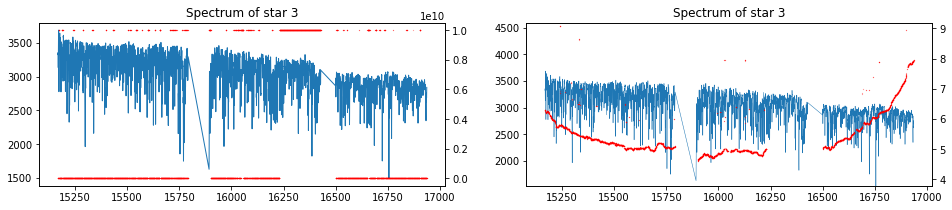

In [215]:
titles = ["Spectrum of star 1", "Spectrum of star 2", "Spectrum of star 3"]
for i in range(3):
    flux_data1 = flux_data[i*19]
    flux_error_data1 = flux_error_data[i*19]
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16,3))
    ax1.plot(wl, flux_data1, lw=1)
    ax1.set_title(titles[i])
    #ax1.axvline(x = 1.647, ls="--", c="y"); ax1.axvline(x = 1.696, ls="--", c="y")
    #ax1.axvline(x = 1.585, ls="--", c="y"); ax1.axvline(x = 1.644, ls="--", c="y")
    #ax1.axvline(x = 1.514, ls="--", c="y"); ax1.axvline(x = 1.581, ls="--", c="y")
    ax11 = ax1.twinx()
    ax11.scatter(wl, flux_error_data1, s=0.02, c="r");

    ax2.plot(wl, flux_data1, lw=0.5)
    ax2.set_title(titles[i])
    ax2.set_ylim(0.5*np.median(flux_data1), 1.5*np.median(flux_data1))
    #ax2.axvline(x = 1.647, ls="--", c="y"); ax2.axvline(x = 1.696, ls="--", c="y")
    #ax2.axvline(x = 1.585, ls="--", c="y"); ax2.axvline(x = 1.644, ls="--", c="y")
    #ax2.axvline(x = 1.514, ls="--", c="y"); ax2.axvline(x = 1.581, ls="--", c="y")
    ax22 = ax2.twinx()
    ax22.scatter(wl, flux_error_data1, s=0.02, c="r");
    ax22.set_ylim(0.7*np.median(flux_error_data1), 1.7*np.median(flux_error_data1))

## 2.3 Label extraction
The AllStars file provided by APOGEE contains labels derived by ASPCAP. We will use these labels.

The labels are stored by location and object IDs, which we have, so we simply parse the file and extract the following labels for each star:
* Teff: Effective Temperature: 
* Log(g):
* Fe/H: 
* Mg/Fe
* Si/Fe

In addition, the file contains the SNR(signal to noise ratio) information for each star.

Some stars shows up more than once (identical target_ids) in the ASPCAP file. This might be due to multiple observations, that for some reason aren't counted as multiple visits. Either way, for simplicity we will choose whatever file shows the lower SNR, as that is a naive indication of better data.

In [47]:
label_names = ["Teff", "Log(g)", "Fe/H", "Mg/Fe", "Si/Fe"]
labels = np.zeros((5, nr_stars), dtype=np.float32) # Direct pandas assignment was super slow for some reason, 
SNR_data = np.zeros(nr_stars, dtype=np.float32)    # so we're temp-storing data in these arrays.

with fits.open('stars/allStar-l31c.2.fits') as label_file:
    label_data = label_file[1].data
    duplicates = 0
    for i in tqdm(range(nr_stars)):
        target_id = data['loc_id'][i] + '.' + data['obj_id'][i]
        matches =  np.argwhere(label_data['TARGET_ID'] == data['target_id'][i])
        if len(matches) > 1: # Some har multiple TARGET_IDs. Just pick the one with highest SNR.
            duplicates += 1
            idx = matches[np.argmax(label_data['SNR'][matches])]
        else:
            idx = matches[0]
        labels[0,i] = label_data['Teff'][idx]
        labels[1,i] = label_data['logg'][idx]
        labels[2,i] = label_data['FE_H'][idx]
        labels[3,i] = label_data['MG_FE'][idx]
        labels[4,i] = label_data['SI_FE'][idx]
        SNR_data[i] = label_data['SNR'][idx]

data['Teff'] = labels[0].copy()
data['logg'] = labels[1].copy()
data['FeH'] = labels[2].copy()
data['MgFe'] = labels[3].copy()
data['SiFe'] = labels[4].copy()
data['SNR'] = SNR_data.copy()

del label_data, labels
print(f"There were {duplicates} duplicates out of {nr_stars} stars.")




  0%|          | 0/1692 [00:00<?, ?it/s]


  0%|          | 1/1692 [00:00<05:43,  4.92it/s]


  1%|          | 9/1692 [00:00<04:06,  6.82it/s]


  1%|          | 17/1692 [00:00<02:58,  9.38it/s]


  1%|▏         | 25/1692 [00:00<02:11, 12.71it/s]


  2%|▏         | 33/1692 [00:00<01:38, 16.91it/s]


  2%|▏         | 41/1692 [00:00<01:15, 21.98it/s]


  3%|▎         | 49/1692 [00:00<00:59, 27.80it/s]


  3%|▎         | 57/1692 [00:00<00:47, 34.22it/s]


  4%|▍         | 65/1692 [00:01<00:39, 40.84it/s]


  4%|▍         | 73/1692 [00:01<00:34, 47.19it/s]


  5%|▍         | 81/1692 [00:01<00:30, 52.29it/s]


  5%|▌         | 89/1692 [00:01<00:28, 56.92it/s]


  6%|▌         | 97/1692 [00:01<00:26, 60.05it/s]


  6%|▌         | 105/1692 [00:01<00:25, 62.49it/s]


  7%|▋         | 112/1692 [00:01<00:25, 62.39it/s]


  7%|▋         | 119/1692 [00:01<00:24, 63.04it/s]


  7%|▋         | 126/1692 [00:01<00:24, 64.76it/s]


  8%|▊         | 133/1692 [00:02<00:23, 66.19it/s]


  8%|▊         

 59%|█████▉    | 997/1692 [00:14<00:10, 65.06it/s]


 59%|█████▉    | 1004/1692 [00:14<00:10, 63.61it/s]


 60%|█████▉    | 1011/1692 [00:14<00:10, 63.83it/s]


 60%|██████    | 1018/1692 [00:14<00:10, 63.39it/s]


 61%|██████    | 1025/1692 [00:14<00:10, 64.16it/s]


 61%|██████    | 1032/1692 [00:15<00:10, 64.80it/s]


 61%|██████▏   | 1039/1692 [00:15<00:10, 65.01it/s]


 62%|██████▏   | 1046/1692 [00:15<00:09, 64.95it/s]


 62%|██████▏   | 1053/1692 [00:15<00:09, 65.44it/s]


 63%|██████▎   | 1060/1692 [00:15<00:09, 65.94it/s]


 63%|██████▎   | 1067/1692 [00:15<00:09, 66.18it/s]


 63%|██████▎   | 1074/1692 [00:15<00:09, 66.40it/s]


 64%|██████▍   | 1081/1692 [00:15<00:09, 66.63it/s]


 64%|██████▍   | 1088/1692 [00:15<00:09, 66.55it/s]


 65%|██████▍   | 1095/1692 [00:16<00:09, 65.53it/s]


 65%|██████▌   | 1102/1692 [00:16<00:09, 65.21it/s]


 66%|██████▌   | 1109/1692 [00:16<00:08, 65.08it/s]


 66%|██████▌   | 1116/1692 [00:16<00:08, 65.96it/s]


 66%|██████▋   | 1123/1692 [0

There were 43 duplicates out of 1692 stars.


In [48]:
data.describe()

,Teff,logg,FeH,MgFe,SiFe,SNR
count,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000
mean,4589.384766,2.280169,-0.024437,0.071188,0.029521,225.095001
std,367.622925,0.663078,0.272083,0.104561,0.085485,199.544601
min,3581.524658,0.061446,-0.974775,-0.227274,-0.464714,50.289001
25%,4332.375122,1.874440,-0.197139,0.001872,-0.018280,95.353472
50%,4657.134277,2.414732,0.025364,0.043010,0.013149,150.639999
75%,4865.310547,2.636597,0.175844,0.111468,0.066043,275.450745
max,5455.403809,3.739455,0.536556,0.430676,0.389394,1922.119995


# Cuts
Applying cuts:

In [49]:
cut_idx = (data['Teff'].values != -9999.) & (data['logg'] != -9999.) & (data['FeH'] != -9999.) \
        & (data['MgFe'] != -9999.) & (data['SiFe'] != -9999.) \
        & (data['SNR'] > 50) & (data['FeH'] > -1) & (flux_data != 0.).any(axis=1)

data = data[cut_idx]
data = data.reset_index(drop=True)
flux_data = flux_data[cut_idx]
flux_error_data = flux_error_data[cut_idx]
nr_stars = len(data['Teff'])
print(f"Cut reduced number of objects to {nr_stars}")

Cut reduced number of objects to 1692


# Freq knockouts

In [212]:
wavelengths = np.load("wavelength.npy")
cut_mask = np.zeros(nr_pixels, dtype=bool)
cut_mask[322:3242] = True; cut_mask[3700:6100] = True; cut_mask[6412:8306] = True
wl = wl[cut_mask]
flux_data = flux_data[:, cut_mask]
flux_error_data = flux_error_data[:, cut_mask]

In [213]:
data.describe()

,Teff,logg,FeH,MgFe,SiFe,SNR
count,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000,1692.000000
mean,4589.384766,2.280169,-0.024437,0.071188,0.029521,225.095001
std,367.622925,0.663078,0.272083,0.104561,0.085485,199.544601
min,3581.524658,0.061446,-0.974775,-0.227274,-0.464714,50.289001
25%,4332.375122,1.874440,-0.197139,0.001872,-0.018280,95.353472
50%,4657.134277,2.414732,0.025364,0.043010,0.013149,150.639999
75%,4865.310547,2.636597,0.175844,0.111468,0.066043,275.450745
max,5455.403809,3.739455,0.536556,0.430676,0.389394,1922.119995


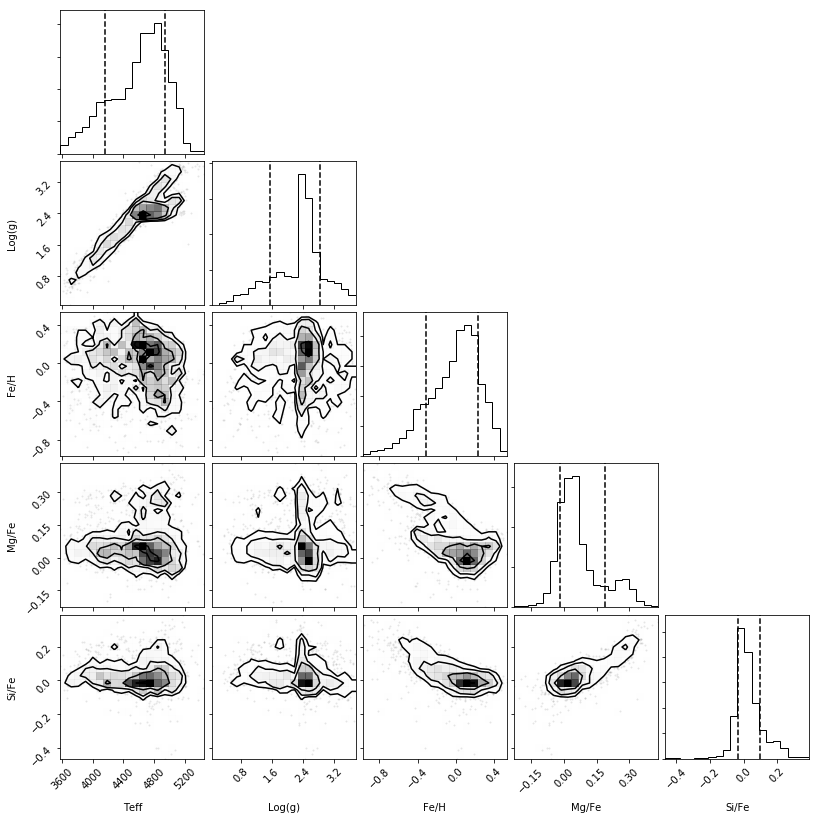

In [214]:
fig = corner.corner(data[['Teff','logg','FeH','MgFe','SiFe']], labels=label_names, quantiles=[0.16, 0.84]);

# Applying bitmasks on bad data
APOGEE provides a "possible error" bitmask for each pixel of each star. The meaning of each bit is explained [here](https://www.sdss.org/dr14/algorithms/bitmasks/#APOGEE_PIXMASK), but they all indicate that something might be wrong with the pixel. Therefore, we will simply assume that any pixel with non-zero mask value (which means no flag is set) is bad. We will set the uncertainty of all bad pixels to be large.

An improvement on this would be to dive into more detail on each bit flag, and set a more moderate error-increase on less serious flags.

In [52]:
for i in tqdm(range(nr_stars)):
    flux_error_data[i, bitmask[i] != 0] = 1e10




  0%|          | 0/1692 [00:00<?, ?it/s]


100%|██████████| 1692/1692 [00:00<00:00, 30228.57it/s]

# Pseudo-normalize
## TODO: Remove x% outliers, maybe several times in an iterative process. 

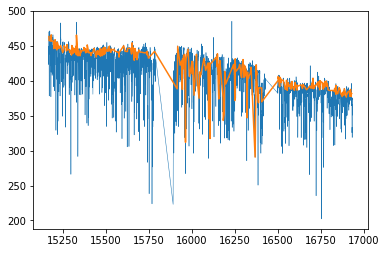

In [241]:
pixels_cannon = np.load("pixels_cannon.npy")
clean_spectrum = flux_data[:, pixels_cannon]
clean_error_spectrum = flux_error_data[:, pixels_cannon]
clean_wl = wl[pixels_cannon]
plt.plot(wl, flux_data[0], lw=0.5)
plt.plot(clean_wl, clean_spectrum[0])

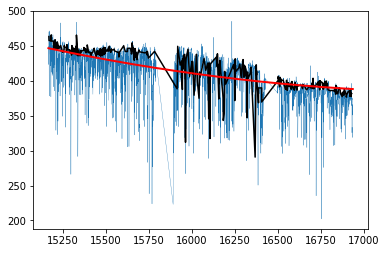

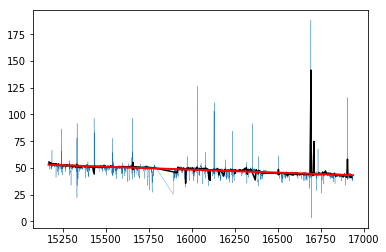

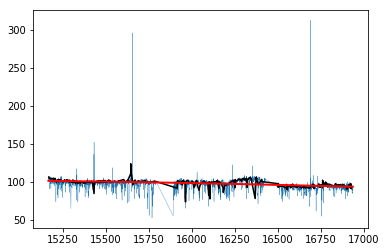

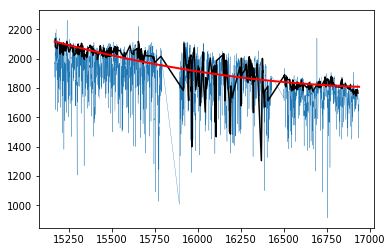

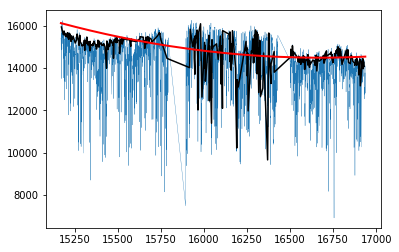

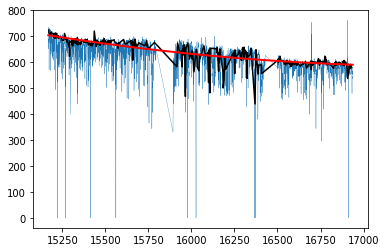

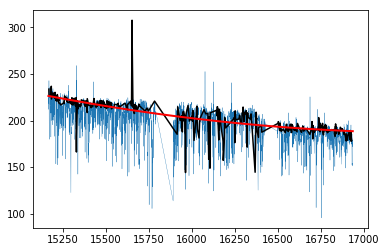

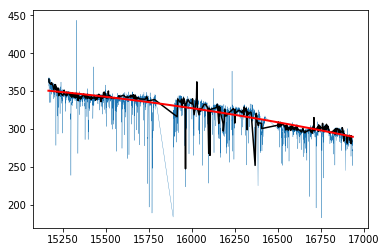

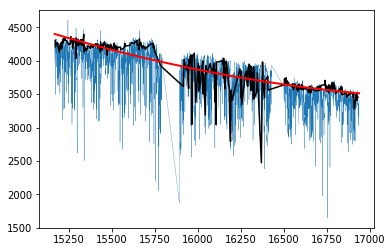

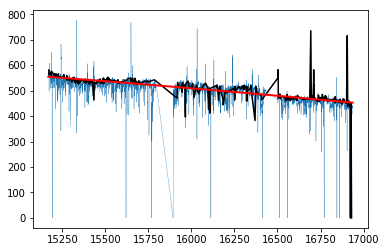

In [255]:
for i in range(10):
    plt.figure()
    p2, p1, p0 = np.polyfit(clean_wl, clean_spectrum[i], deg=2, w=1/clean_error_spectrum[i])
    plt.plot(wl, flux_data[i], lw=0.3)
    plt.plot(clean_wl, clean_spectrum[i], c="k")
    plt.plot(wl, p0 + p1*wl + p2*wl**2, lw=2, c="r")

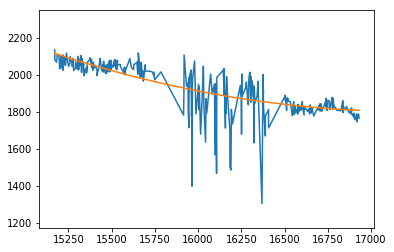

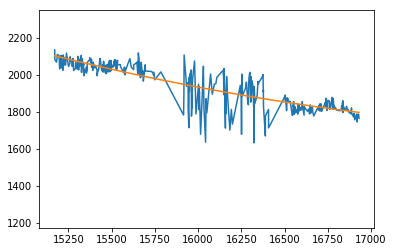

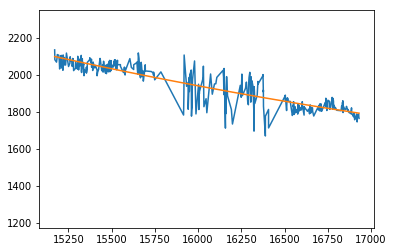

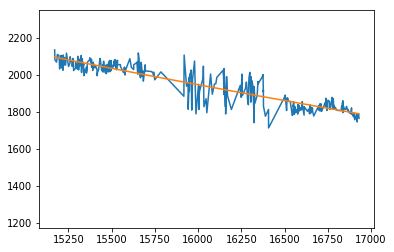

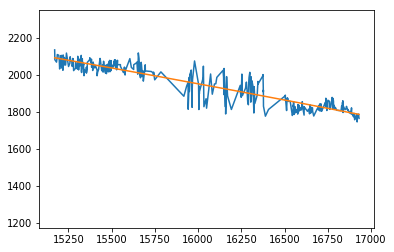

In [269]:
j = 3

new_spec = clean_spectrum[j].copy()
new_err = clean_error_spectrum[j].copy()
new_wl = clean_wl.copy()
ymax, ymin = np.max(new_spec)*1.1, np.min(new_spec)*0.9

for i in range(5):
    p2, p1, p0 = np.polyfit(new_wl, new_spec, deg=2, w=1/new_err)
    poly = p0 + p1*new_wl + p2*new_wl**2
    plt.figure()
    plt.plot(new_wl, new_spec)
    plt.plot(new_wl, poly)
    plt.ylim(ymin, ymax)
    
    p99 = np.percentile(np.abs(poly-new_spec), 99)
    cut_idx = np.abs(poly-new_spec) < p99
    new_spec = new_spec[cut_idx]
    new_wl = new_wl[cut_idx]
    new_err = new_err[cut_idx]

In [234]:
for i in range(nr_stars):
    p80 = np.percentile(flux_data[i], 80)
    flux_data[i] = flux_data[i]/p80
    flux_error_data[i] = flux_error_data[i]/p80

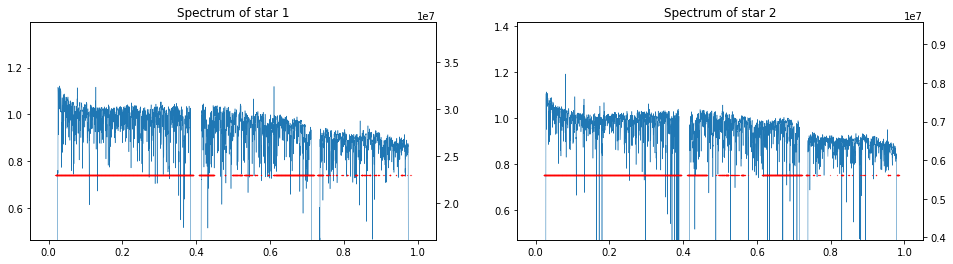

In [235]:
x = np.linspace(0, 1, len(flux_data1))
titles = ["Spectrum of star 1", "Spectrum of star 2", "Spectrum of star 3"]
fig, ax = plt.subplots(1, 2, figsize=(16,4))
for i in range(2):
    flux_data1 = flux_data[i*19]
    flux_error_data1 = flux_error_data[i*19]
    ax[i].plot(x, flux_data1, lw=0.5)
    ax[i].set_title(titles[i])
    ax[i].set_ylim(0.5*np.median(flux_data1), 1.5*np.median(flux_data1))
    ax[i] = ax[i].twinx()
    ax[i].scatter(x, flux_error_data1, s=0.02, c="r");
    ax[i].set_ylim(0.7*np.median(flux_error_data1), 1.7*np.median(flux_error_data1))

# Rescaling labels

# MACHINE LEARNING BITCHES
Some experimenting reveals that pixel 4634, corresponding to the wavelength 1.6123657569 microns, usually varies a lot. We will use this in our initial fitting.

1.6123657569395848

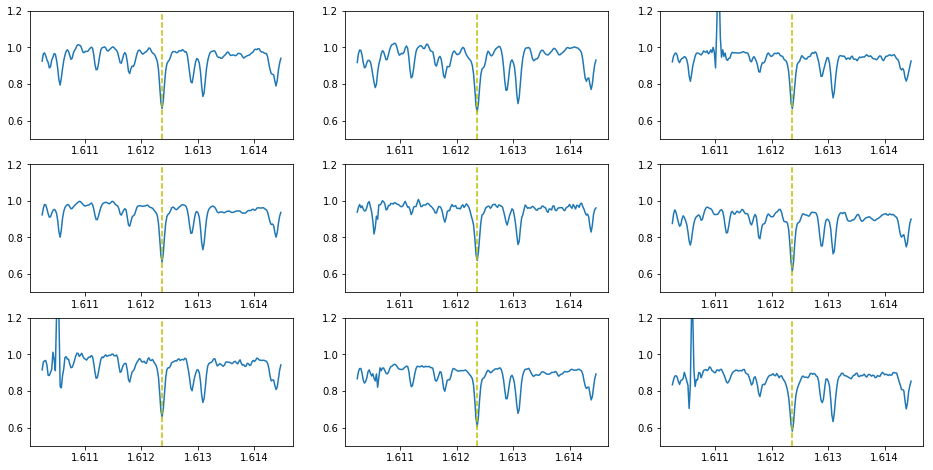

In [236]:
fig, ax = plt.subplots(3, 3, figsize=(16,8))
chosen_idx = 4634
chosen_wl = wl[4634]
for i in range(9):
    flux_data1 = flux_data[i*29]
    ax[i//3, i%3].plot(wl[chosen_idx-100:chosen_idx+100], flux_data1[chosen_idx-100:chosen_idx+100])
    ax[i//3, i%3].axvline(x=wl[chosen_idx], ls="--", c="y")
    ax[i//3, i%3].set_ylim(0.5, 1.2)
chosen_wl

In [237]:
onepxl_flux_data = flux_data[:, chosen_idx, None]
onepxl_flux_error_data = flux_error_data[:, chosen_idx, None]

# KERAS

Our initial model will have 5 input nodes, corresponding to the 5 labels we have constructed, and 1 output node, corresponding to the one wavelength pixel we have chosen.

In [247]:
import tensorflow as tf
from tensorflow import keras
from keras.models import Sequential  # linear stack of layers
from keras.layers import Dense, Activation

from keras.wrappers.scikit_learn import KerasRegressor
from sklearn import preprocessing
from sklearn.model_selection import cross_val_score, KFold, train_test_split
from sklearn.metrics import mean_squared_error

print(tf.__version__)

1.13.1


In [239]:
input_train, input_test, output_train, output_test = train_test_split(data[['Teff','logg','FeH','MgFe','SiFe']].values, onepxl_flux_data, test_size=0.33, random_state=42, shuffle=True)

pt = preprocessing.PowerTransformer()  
input_train_scaled = pt.fit_transform(input_train)
input_test_scaled = pt.transform(input_test)

pty = preprocessing.PowerTransformer()
pty.fit(output_train)
output_train_scaled = pty.transform(output_train)
output_test_scaled = pty.transform(output_test)

/usr/local/lib/python3.6/dist-packages/numpy/core/_methods.py:121: RuntimeWarning: overflow encountered in multiply
  x = um.multiply(x, x, out=x)


In [240]:
input_train.shape, input_test.shape, output_train.shape, output_test.shape

((1104, 5), (545, 5), (1104, 1), (545, 1))

(array([  2.,   0.,  24., 269., 618., 176.,   9.,   3.,   2.,   1.]),
 array([-5.7279096 , -4.4213424 , -3.1147747 , -1.8082074 , -0.50164   ,
         0.80492735,  2.1114948 ,  3.4180622 ,  4.7246294 ,  6.031197  ,
         7.3377643 ], dtype=float32),
 <a list of 10 Patch objects>)

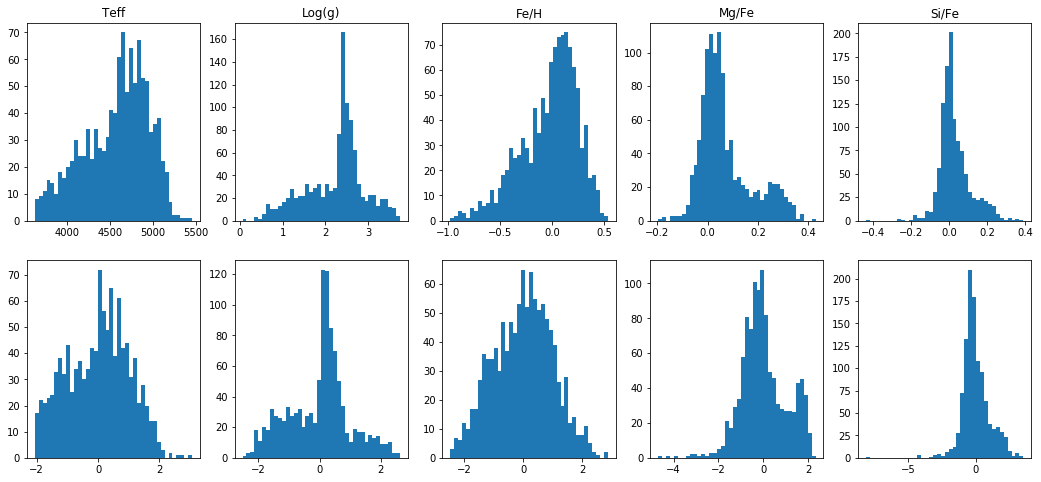

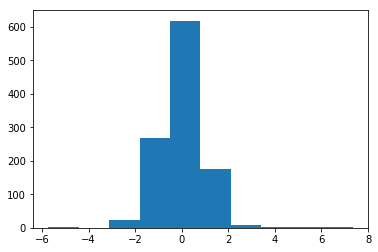

In [241]:
fig, ax = plt.subplots(2, 5, figsize=(18,8))
labels = ['T']
for i in range(5):
    ax[0,i].set_title(label_names[i])
    ax[0,i].hist(input_train[:,i], bins=40)
    ax[1,i].hist(input_train_scaled[:,i], bins=40)

plt.figure()
plt.hist(output_train_scaled)

In [242]:
onepxl_flux_data[114]

array([0.5344826], dtype=float32)

In [243]:
def nn_clf():
    model = Sequential()
    model.add(Dense(10, input_shape=(5,), activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(10,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(5,  activation="relu", kernel_initializer='random_uniform'))
    model.add(Dense(1, activation="relu", kernel_initializer='random_uniform'))
    model.compile(optimizer='adam', loss='mean_squared_error',  metrics=['mae',"mse"])
    return model

In [244]:
nn_clf().summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_13 (Dense)             (None, 10)                60        
_________________________________________________________________
dense_14 (Dense)             (None, 10)                110       
_________________________________________________________________
dense_15 (Dense)             (None, 5)                 55        
_________________________________________________________________
dense_16 (Dense)             (None, 1)                 6         
Total params: 231
Trainable params: 231
Non-trainable params: 0
_________________________________________________________________


In [245]:
clf = KerasRegressor(build_fn=nn_clf, batch_size=32, epochs=50)
clf.fit(input_train_scaled, output_train)

Epoch 1/50
1104/1104 [==============================] - 0s 192us/step - loss: 0.4089 - mean_absolute_error: 0.6370 - mean_squared_error: 0.4089
Epoch 2/50
1104/1104 [==============================] - 0s 21us/step - loss: 0.3435 - mean_absolute_error: 0.5832 - mean_squared_error: 0.3435
Epoch 3/50
1104/1104 [==============================] - 0s 21us/step - loss: 0.2113 - mean_absolute_error: 0.4506 - mean_squared_error: 0.2113
Epoch 4/50
1104/1104 [==============================] - 0s 22us/step - loss: 0.0559 - mean_absolute_error: 0.2088 - mean_squared_error: 0.0559
Epoch 5/50
1104/1104 [==============================] - 0s 24us/step - loss: 0.0119 - mean_absolute_error: 0.0871 - mean_squared_error: 0.0119
Epoch 6/50
1104/1104 [==============================] - 0s 24us/step - loss: 0.0077 - mean_absolute_error: 0.0686 - mean_squared_error: 0.0077
Epoch 7/50
1104/1104 [==============================] - 0s 25us/step - loss: 0.0065 - mean_absolute_error: 0.0620 - mean_squared_error: 0.006

MSE 0.04129785


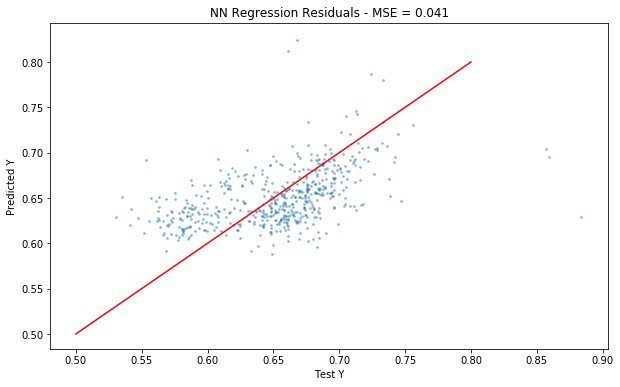

In [249]:
mse = np.sqrt(mean_squared_error(output_test, clf.predict(input_test_scaled))) ; print("MSE",mse)

plt.figure(figsize=(10,6))
plt.title("NN Regression Residuals - MSE = %.3f" % mse)
plt.scatter(output_test, clf.predict(input_test_scaled), alpha=0.4, s=3)
plt.xlabel("Test Y")
plt.ylabel("Predicted Y")
plt.plot([0.5,0.8],[0.5,0.8],c="r")